# Bias Variance Trade-Off



The bias–variance tradeoff is a central problem in supervised learning. The error of a machine learning model consists of 3 parts:

$MSE = variance + bias^2 + noise$ 

The noise is also called *irreducible error*, it cannot be reduced by applying different models.
The variance and bias term is influenced by the flexibility of the chosen model.


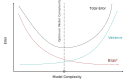

In [1]:
from IPython.display import SVG, display
url = 'https://upload.wikimedia.org/wikipedia/commons/9/9f/Bias_and_variance_contributing_to_total_error.svg'
display(SVG(url))

Normally, our goal is to minimize the total error (for example the mean squared error). Therefore, we would like to minimize the bias and variance term of the error.

Unfortunately, it is typically impossible to do both simultaneously. **High-variance learning methods** may be able to represent their training set well but are at risk of **overfitting** to noisy or unrepresentative training data. In contrast, algorithms with **high bias** typically produce simpler models that may fail to capture important regularities (i.e. **underfit**) in the data.

This is called the **bias-variance tradeoff**. What it means is that it might be wise to use a biased estimator, so long as it reduces our variance, assuming our goal is to minimize squared error.

Learning Objectives

In this notebook you will learn...

* how to split you data into a train and a test set using `train_test_split`
* how to create more flexible linear models by using polynomial features
* how to use the root mean squared error to evaluate your model's performance
* to define bias and variance
* what the bias variance trade-off is and see its implications on a specific example


## Setup and Import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import operator
# import to divide our data into train and test data
from sklearn.model_selection import train_test_split
# import to create polynomial features
from sklearn.preprocessing import PolynomialFeatures
# import of the linear regression model
from sklearn.linear_model import LinearRegression
# import of our evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

RSEED = 12

In [3]:
# Set constants and plotting parameters
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['figure.figsize'] = (8,6)

## Defining our Data




Normally we wouldn't know the true relationship between the independent features (X) and our dependent variable (y). But to get an idea about the bias-variance tradeoff it is helpful to know the true relationship between those variables.
Here, we know this relationship because we define it in our data generating process.

We will choose x in the range from -7 to 7. And the true relationship between x and y is:


$y = 10x - 2 x^2 + 0.5 x^3 + \epsilon$

The $\epsilon$ is introducing some random and unpredictable noise to our data.



In [4]:
# generate random data 
np.random.seed(4)
# generating 100 random x-values between -7 and 7
x = np.random.uniform(-7,7,size=100)

# generating corresponding y variable according to our defined true relationship
# adding some random noise with np.random.normal with mu = 0 and std = 20
y = 10 * x - 2 * (x ** 2) + 0.5 * (x ** 3) + np.random.normal(0, 20, 100)

# transforming the data to include another axis since this is expected for modelling with scikit-learn
x = x[:, np.newaxis]
y = y[:, np.newaxis]

## Train-Test Split



Most often, one goal of your data science projects is to train a model to make predictions for new instances. But training a model alone does not guarantee you that it will perform well on unseen data. Before we can "trust" our model and put it into production, we need to evaluate its performance on data on which it has **not** been trained. 

The simplest way to do this is to split our original dataset into a training dataset and a test dataset. The training dataset, as the name suggests, is used to fit (train) our model. We can then evaluate this model against the test dataset, which contains only instances that our model has never seen. Luckily, we do not have to split our dataset manually. We can make use of scikit-learns [`train-test-split()` function](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 

In [5]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=RSEED) #Careful here: this is an unusual choice for the test_size. See paragraph below for more explainations.


In [6]:
# Size of train and test set
print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test: ", y_test.shape)

X_train:  (20, 1)
y_train:  (20, 1)
X_test:  (80, 1)
y_test:  (80, 1)


In the cells above we called the `train_test_split()` function on our feature(s) and target. We have also defined what percentage of the entire data set should end up in the test set (`test_size`).


Another important parameter is `random_state`: without setting a random state, scikit-learn will **randomly** shuffle your data when calling the function and assign instances to the test set. As a result, the scores of your model will change across multiple function calls. In order to reproduce the same results each time you call a notebook or script, you need to control the shuffling that is applied to the data. You can do this by setting the parameter `random_state`. 


    Exercise:

    The documentation of scikit-learn is very valuable. Have a look at the scikit-learn page for train-test-split. What is the default value for the test_size? 

The default values of scikit-learn are always a good starting point and a benchmark. So why are we deviating so much from the norm here? 

There are two competing concerns: with less training data, your parameter estimates have greater variance. With less testing data, your performance statistic will have greater variance. Broadly speaking you should be concerned with dividing data such that neither variance is too high, which is more to do with the absolute number of instances in each category rather than the percentage.

In our case here, we want to show what "greater variance" for the estimated parameter means, therefore our split is a bit unconventionally. 


Let's have a look at our data. It is always good to get a feeling of the train and test data, and if these are coming from the same distribution or varying a lot. 

In [7]:
x_plot = np.linspace(-7,7,500)
y_plot_true = 10 * x_plot - 2 * (x_plot ** 2) + 0.5 * (x_plot ** 3)

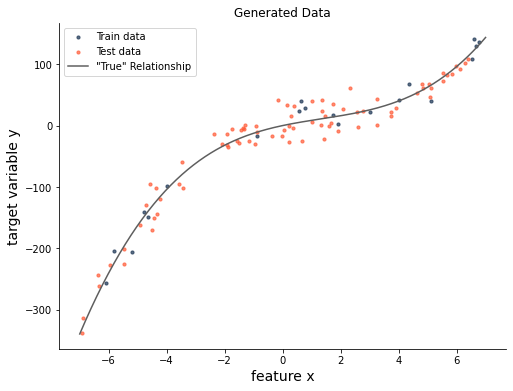

In [8]:
# Plotting 
plt.scatter(X_train, y_train, s=10,c="#193251",alpha=0.7, label="Train data")
plt.scatter(X_test, y_test, s=10,c="#FF5A36",alpha=0.7, label="Test data")
plt.plot(x_plot,y_plot_true,c="#5E5E5E",label= '"True" Relationship')
plt.legend()
plt.xlabel("feature x")
plt.ylabel("target variable y")
plt.title("Generated Data")
plt.show();

The true relationship is exactly our data generating process:


$y = 10x - 2 x^2 + 0.5 x^3 + \epsilon$


The data varies from this line, by the random error we have added as well.

Overall, the train data spans nearly the same range in feature x as the test data. Only in the very negative range (< -6) there are no training data.

## Modelling


We will try out different models on our generated data. By using different flexible models, we will also see the effect of bias and variance of these models.



### First model: linear regression




After we defined our feature(s) and target and also split the data into a train and test set, we can start now with the actual modelling part. As a first step we create an instance of the `LinearRegression()` model. Then we fit the model via `.fit()` using our **train dataset**. In the last step we can make predictions on our **test data** using the `.predict()` method.

Since the `LinearRegression` model from scikit-learn expects a 2D-array we have added another axis to our data at the beginning of the notebook.

In [11]:
# Instantiate our model 
#lin_reg = 
lin_reg = LinearRegression()
# Fit the model using our train data 
lin_reg.fit(X_train, y_train)

# Make predictions on the test data and save those in "y_pred"
#y_pred = 
y_pred_test = lin_reg.predict(X_test)
y_pred_train = lin_reg.predict(X_train)

So far we have trained a model and made predictions on our test set. Now it's time to evaluate the performance of the model. We will print the R-squared and the RMSE. Scikit-learn doesn't provide a function for calculating the RMSE directly, but it offers the possibility to set the parameter `squared = False` when calculating the mean squared error which then returns the RMSE.

In [12]:
# Calculate metric
def calculate_metrics(y_train, y_pred_train, y_test, y_pred_test):
    """Calculate and print out RMSE and R2 for train and test data

    Args:
        y_train (array): true values of y_train
        y_pred_train (array): predicted values of model for y_train
        y_test (array): true values of y_test
        y_pred_test (array): predicted values of model for y_test
    """

    print("Metrics on training data") 
    rmse = np.sqrt(mean_squared_error(y_train,y_pred_train))
    r2 = r2_score(y_train,y_pred_train)
    print("RMSE:", round(rmse, 3))
    print("R2:", round(r2, 3))
    print("---"*10)
    
    # Calculate metric
    print("Metrics on test data")  
    rmse = mean_squared_error(y_test, y_pred_test, squared=False)
    # you can get the same result with this line:
    # rmse = np.sqrt(mean_squared_error(y_test,y_pred_test))

    r2 = r2_score(y_test,y_pred_test)
    print("RMSE:", round(rmse, 3))
    print("R2:", round(r2, 3))
    print("---"*10)

In [13]:
print("Linear Regression Model:")
print("---"*10)
calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)

Linear Regression Model:
------------------------------
Metrics on training data
RMSE: 33.084
R2: 0.921
------------------------------
Metrics on test data
RMSE: 43.733
R2: 0.789
------------------------------


In [14]:
print('Standard deviation of y:', np.std(y))
print('Mean of y:', np.mean(y))

Standard deviation of y: 100.12966121017597
Mean of y: -21.959318513105412


The optimal RMSE would be 0, which means that all predictions matched the expected values exactly.
Here, we see, that the RMSE on the training data is with 33 smaller thant the RMSE on the test data (44).
This is typical, as we calculated our coefficients based on the training data, the model is prone to fit the training data better than the unknown test data.

Let's look at our model graphically.

In [15]:
line_lin_reg = lin_reg.intercept_ + lin_reg.coef_[0]*x_plot

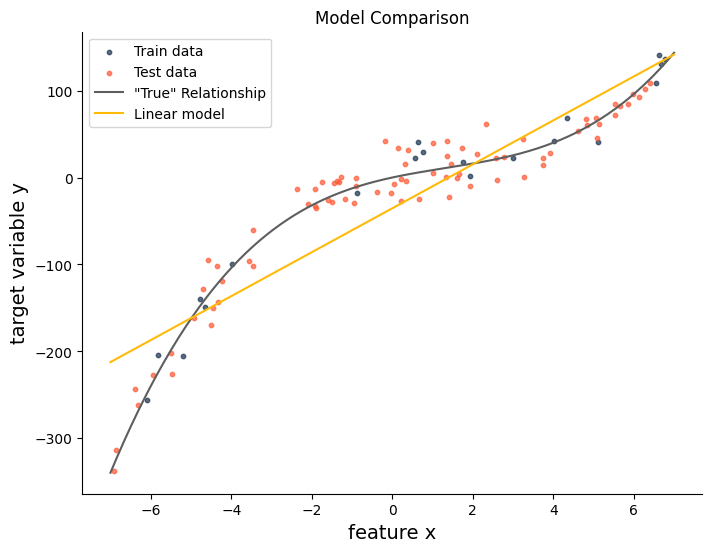

In [16]:
# Plotting 
plt.scatter(X_train, y_train, s=10,c="#193251",alpha=0.7, label="Train data")
plt.scatter(X_test, y_test, s=10,c="#FF5A36",alpha=0.7, label="Test data")
plt.plot(x_plot,y_plot_true,c="#5E5E5E",label= '"True" Relationship')
plt.plot(x_plot,line_lin_reg,c="#FFBA08",label= 'Linear model')
plt.legend()
plt.xlabel("feature x")
plt.ylabel("target variable y")
plt.title("Model Comparison")
plt.show();

We can see that the straight line is unable to capture the patterns in the data. This is an example of **underfitting**. The linear model is not flexible enough to capture the true relationship of x and y. This is called a **biased** model. The model has strong pre-assumptions about the relationship between x and y: that there is a linear relationship.

With only one feature, we are able to see how our model performs by looking an the feature-target plot. But if we have multiple feature, this graph is not available for us anymore. To still be able to evaluate the model performance, we can plot the true y values vs. the predicted values and plot our residuals. With these plots we check if the residuals are random normal distributed (ideal situation) or if we see some pattern (still improvement of model possible!).

In [17]:

def error_analysis(y_test, y_pred_test):
    """Generated true vs. predicted values and residual scatter plot for models

    Args:
        y_test (array): true values for y_test
        y_pred_test (array): predicted values of model for y_test
    """     
    # Calculate residuals
    residuals = y_test - y_pred_test
    
    # Plot real vs. predicted values 
    fig, ax = plt.subplots(1,2, figsize=(15, 5))
    plt.subplots_adjust(right=1)
    plt.suptitle('Error Analysis')
    
    ax[0].scatter(y_pred_test, y_test, color="#FF5A36", alpha=0.7)
    ax[0].plot([-400, 350], [-400, 350], color="#193251")
    ax[0].set_title("True vs. predicted values", fontsize=16)
    ax[0].set_xlabel("predicted values")
    ax[0].set_ylabel("true values")
    ax[0].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[0].set_ylim((y_test.min()-40), (y_test.max()+40))
    
    ax[1].scatter(y_pred_test, residuals, color="#FF5A36", alpha=0.7)
    ax[1].plot([-400, 350], [0,0], color="#193251")
    ax[1].set_title("Residual Scatter Plot", fontsize=16)
    ax[1].set_xlabel("predicted values")
    ax[1].set_ylabel("residuals")
    ax[1].set_xlim((y_pred_test.min()-10), (y_pred_test.max()+10))
    ax[1].set_ylim((residuals.min()-10), (residuals.max()+10));

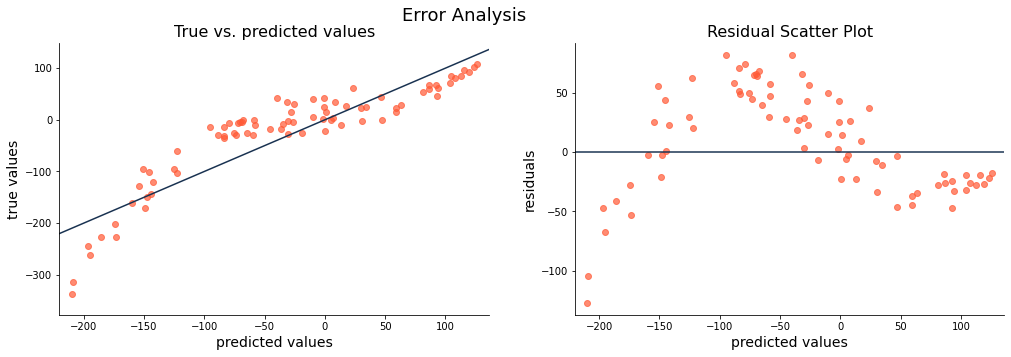

In [16]:
error_analysis(y_test, y_pred_test)

Since

Residual = Observed – Predicted

…positive values for the residual (on the y-axis) mean the prediction was too low, and negative values mean the prediction was too high; 0 means the guess was exactly correct.

Optimally the residuals,
- (1) are pretty symmetrically distributed, tending to cluster towards the middle of the plot.
- (2) they’re clustered around the lower single digits of the y-axis (e.g., 0.5 or 1.5, not 30 or 150).
- (3) in general, there aren’t any clear patterns.

Ok. We still see some patterns, that our model is not capturing. Fox x-values under -150, we always overestimate the y value, between -150 and circa 0, we always underestimate the y value. For x values above 0 the target value is again generally overestimated.

This is again displaying the underfitting of our highly biased model.



### Second model: linear regression with polynomial features



To overcome underfitting, we need to increase the complexity of the model. We can do this by generating a higher order equation through adding powers of the original features as new features. 
The linear model, 


$\hat{y} = b_0 + b_1x $


can be transformed to

$\hat{y} = b_0 + b_1x + b_2x^2$


This is still considered to be a linear model as the **coefficients/weights** associated with the features are still linear. 

**x²** is only a feature. 

However the curve that we are fitting is quadratic in nature. To convert the original features into their higher order terms we will use the `PolynomialFeature` class provided by scikit-learn. 

In [18]:
# here we will add the second degree polynomial features
polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.transform(X_test)

model_poly = LinearRegression()
model_poly.fit(x_poly_train, y_train)
y_pred_test = model_poly.predict(x_poly_test)
y_pred_train = model_poly.predict(x_poly_train)

In [19]:
print("Polynomial Regression Model (degree 2):")
print("---"*10)
calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)

Polynomial Regression Model (degree 2):
------------------------------
Metrics on training data
RMSE: 27.39
R2: 0.946
------------------------------
Metrics on test data
RMSE: 33.815
R2: 0.874
------------------------------


We can see that the RMSE of the training as well as of the test data could be reduced by adding quadratic features.

In [21]:
line_poly_2_reg = model_poly.intercept_ + model_poly.coef_[0][0] * x_plot + model_poly.coef_[0][1] * x_plot**2

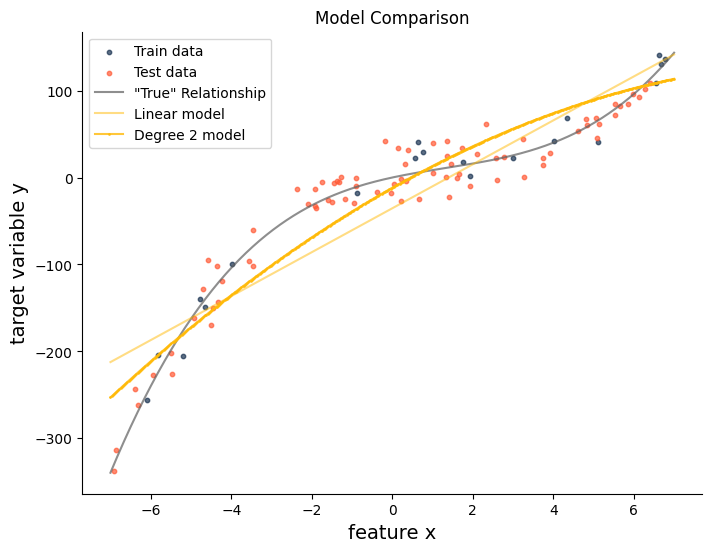

In [22]:
# Plotting 
plt.scatter(X_train, y_train, s=10,c="#193251",alpha=0.7, label="Train data")
plt.scatter(X_test, y_test, s=10,c="#FF5A36",alpha=0.7, label="Test data")
plt.plot(x_plot,y_plot_true,c="#5E5E5E",alpha=0.7, label= '"True" Relationship')
plt.plot(x_plot,line_lin_reg,c="#FFBA08",alpha=0.5,label= 'Linear model')
plt.plot(x_plot,line_poly_2_reg,c="#FFBA08",marker = "o",ms=1, alpha=0.8,label= 'Degree 2 model')
plt.legend()
plt.xlabel("feature x")
plt.ylabel("target variable y")
plt.title("Model Comparison")
plt.show();

Fitting a linear regression model on the transformed features gives the above plot. It is quite clear from the plot that the quadratic curve is able to fit the data better than the linear line. If we compare the `RMSE` and `R²-score` of the two models we can also see the improvement:

| Metric   | RMSE  | R²  | 
|---|---|---|
| **Linear Model**   | 44       |           0.79 | 
| **Polynomial Model (Degree 2)**     |34     |            0.87 | 


 


> We can see that RMSE has decreased and R²-score has increased as compared to the linear line.

Let's have a look at the residual plots... Do you think the points are randomly distributed or can you still se a pattern?

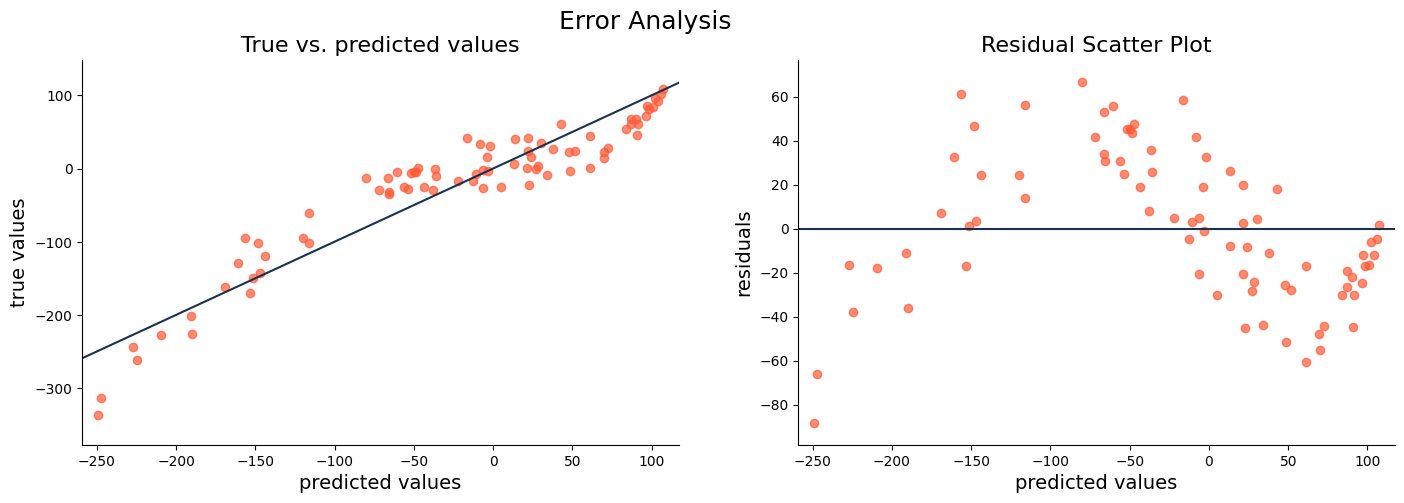

In [23]:
error_analysis(y_test, y_pred_test)

We see, that even though residuals got a bit smaller (linear regression had residuals from -100 to 60), we can still see some obvious patterns. 
Adding even higher degrees of polynomials might help to capture this pattern...

### Linear Model with 3-degree polynomials



Let's add more flexibility. We can also add another degree and fit a cubic curve (degree=3) to the dataset. In the next cell you can try to do it on your own. 

In [24]:
# here we will add the second degree polynomial features
polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.transform(X_test)

model_3_poly = LinearRegression()
model_3_poly.fit(x_poly_train, y_train)
y_pred_test = model_3_poly.predict(x_poly_test)
y_pred_train = model_3_poly.predict(x_poly_train)

In [25]:
print("Polynomial Regression Model (degree 3):")
print("---"*10)
calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)

Polynomial Regression Model (degree 3):
------------------------------
Metrics on training data
RMSE: 15.664
R2: 0.982
------------------------------
Metrics on test data
RMSE: 19.339
R2: 0.959
------------------------------


In [27]:
line_poly_3_reg = model_3_poly.intercept_ + model_3_poly.coef_[0][0] * x_plot + model_3_poly.coef_[0][1] * x_plot**2 + model_3_poly.coef_[0][2] * x_plot**3

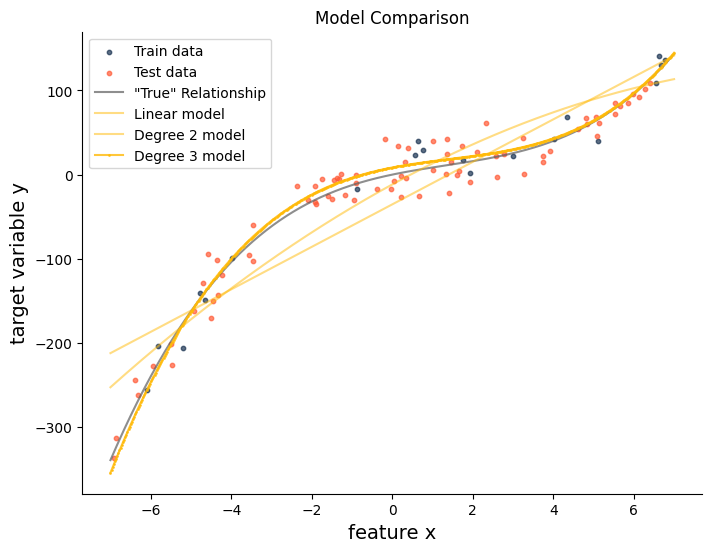

In [28]:
# Plotting 
plt.scatter(X_train, y_train, s=10,c="#193251",alpha=0.7, label="Train data")
plt.scatter(X_test, y_test, s=10,c="#FF5A36",alpha=0.7, label="Test data")
plt.plot(x_plot,y_plot_true,c="#5E5E5E",alpha=0.7, label= '"True" Relationship')
plt.plot(x_plot,line_lin_reg,c="#FFBA08",alpha=0.5,label= 'Linear model')
plt.plot(x_plot,line_poly_2_reg,c="#FFBA08", alpha=0.5,label= 'Degree 2 model')
plt.plot(x_plot,line_poly_3_reg,c="#FFBA08",marker = "o",ms=1, alpha=0.8,label= 'Degree 3 model')
plt.legend()
plt.xlabel("feature x")
plt.ylabel("target variable y")
plt.title("Model Comparison")
plt.show();

In this plot we can see that the linear model with cubic features is almost identical with the data generating process.
The RMSE for the training and test data are also low compared to the other models.


| Metric   | RMSE  | R²  | 
|---|---|---|
| **Linear Model**   | 44       |           0.79 | 
| **Polynomial Model (Degree 2)**     |34     |            0.87 | 
| **Polynomial Model (Degree 3)**     |19     |            0.96 | 

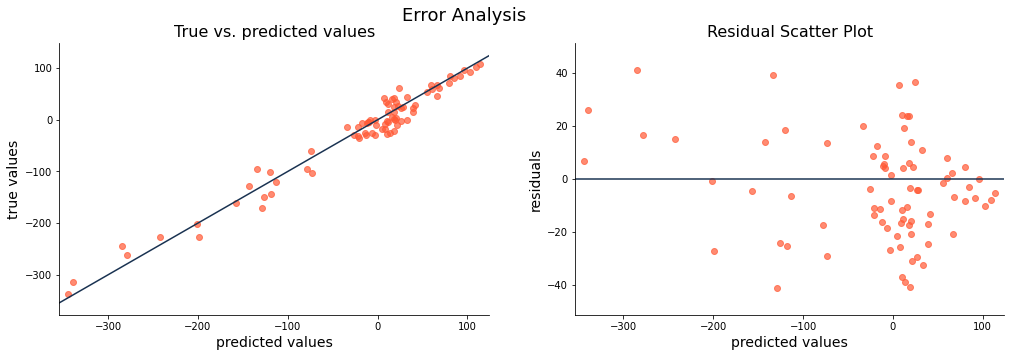

In [26]:
error_analysis(y_test, y_pred_test)

Checking the residual plots, we see that the range of residuals is way smaller and the is no general pattern visible. This hints that the model  is capturing all relationship between features and target variable that is present in the data.


### Linear Model with 8-degree polynomials



Let's try an even more flexible model. This model should also be able to catch the patterns in the data.

In [29]:
# here we will add the second degree polynomial features
polynomial_features = PolynomialFeatures(degree=8, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.transform(X_test)

model_8_poly = LinearRegression()
model_8_poly.fit(x_poly_train, y_train)
y_pred_test = model_8_poly.predict(x_poly_test)
y_pred_train = model_8_poly.predict(x_poly_train)

In [30]:
print("Polynomial Regression Model (degree 8):")
print("---"*10)
calculate_metrics(y_train,y_pred_train, y_test, y_pred_test)

Polynomial Regression Model (degree 8):
------------------------------
Metrics on training data
RMSE: 13.802
R2: 0.986
------------------------------
Metrics on test data
RMSE: 32.916
R2: 0.88
------------------------------


What we see here is a typical sign for overfitting! The RMSE on the training data is pretty low: with 14 even lower than the previous model (15). But on the other side increased the RMSE on the unseen test data enormously! 
Overfitting happens when the model unknowingly extracted some of the residual variation (i.e., the noise) as if that variation represented the underlying relationship. Using this model won't give good results as the included irrelevant information (noise) in the model won't help to predict y for unseen data.

| Metric   | RMSE  | R²  | 
|---|---|---|
| **Linear Model**   | 44       |           0.79 | 
| **Polynomial Model (Degree 2)**     |34     |            0.87 | 
| **Polynomial Model (Degree 3)**     |19     |            0.96 | 
| **Polynomial Model (Degree 8)**     |33     |            0.88 | 


In [31]:
line_poly_8_reg = model_8_poly.intercept_ + model_8_poly.coef_[0][0] * x_plot + model_8_poly.coef_[0][1] * x_plot**2 + model_8_poly.coef_[0][2] * x_plot**3 + model_8_poly.coef_[0][3] * x_plot**4 + model_8_poly.coef_[0][4] * x_plot**5 + model_8_poly.coef_[0][5] * x_plot**6 + model_8_poly.coef_[0][6] * x_plot**7 + model_8_poly.coef_[0][7] * x_plot**8

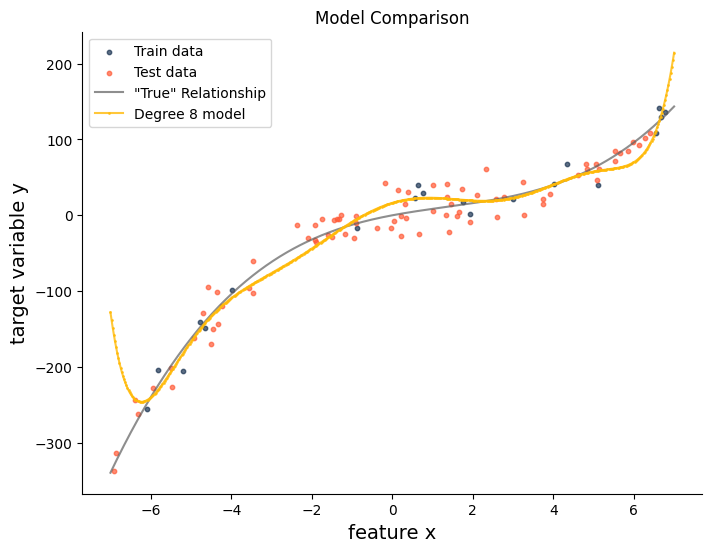

In [32]:
# Plotting 
plt.scatter(X_train, y_train, s=10,c="#193251",alpha=0.7, label="Train data")
plt.scatter(X_test, y_test, s=10,c="#FF5A36",alpha=0.7, label="Test data")
plt.plot(x_plot,y_plot_true,c="#5E5E5E",alpha=0.7, label= '"True" Relationship')
#plt.plot(x_plot,line_lin_reg,c="#FFBA08",alpha=0.5,label= 'Linear model')
#plt.plot(x_plot,line_poly_2_reg,c="#FFBA08", alpha=0.5,label= 'Degree 2 model')
#plt.plot(x_plot,line_poly_3_reg,c="#FFBA08", alpha=0.5,label= 'Degree 3 model')
plt.plot(x_plot,line_poly_8_reg,c="#FFBA08",marker = "o",ms=1, alpha=0.8,label= 'Degree 8 model')
plt.legend()
plt.xlabel("feature x")
plt.ylabel("target variable y")
plt.title("Model Comparison")
plt.show();

This model is way more flexible than the other models we have used so far, it wiggles more to fit the training data. The model with polynomial features up to 8 degree is further away from out data generating process as the previous model.
We see that this line might fit the training data very well, but it's not fitting so well anymore for unknown test data.

Let's just look at the training data for our 4 models. 

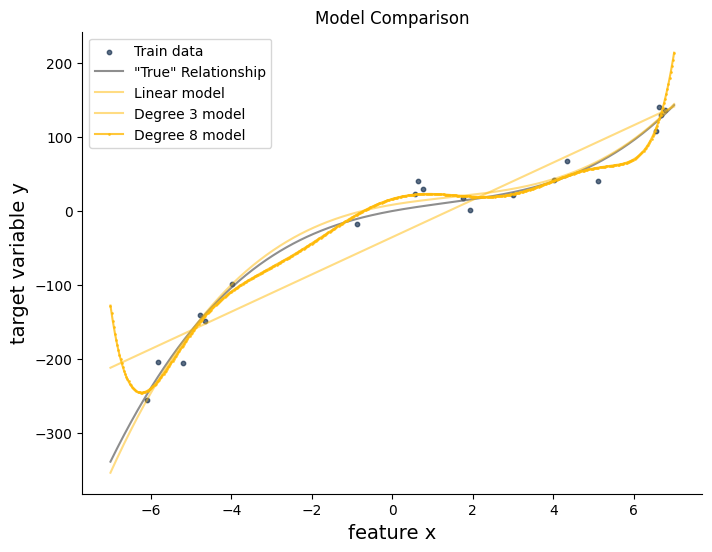

In [33]:
# Plotting 
plt.scatter(X_train, y_train, s=10,c="#193251",alpha=0.7, label="Train data")
#plt.scatter(X_test, y_test, s=10,c="#FF5A36",alpha=0.7, label="Test data")
plt.plot(x_plot,y_plot_true,c="#5E5E5E",alpha=0.7, label= '"True" Relationship')
plt.plot(x_plot,line_lin_reg,c="#FFBA08",alpha=0.5,label= 'Linear model')
#plt.plot(x_plot,line_poly_2_reg,c="#FFBA08", alpha=0.5,label= 'Degree 2 model')
plt.plot(x_plot,line_poly_3_reg,c="#FFBA08", alpha=0.5,label= 'Degree 3 model')
plt.plot(x_plot,line_poly_8_reg,c="#FFBA08",marker = "o",ms=1, alpha=0.8,label= 'Degree 8 model')
plt.legend()
plt.xlabel("feature x")
plt.ylabel("target variable y")
plt.title("Model Comparison")
plt.show();

We can see, that with increasing flexibility, the models fit the training data better. While the linear model with polynomial of oder 1 clearly fails to capture the variation in the data, the linear model with polynomials up to order 8 fit the training data very well but they might also have a hard time on novel instances (= **generalization**).



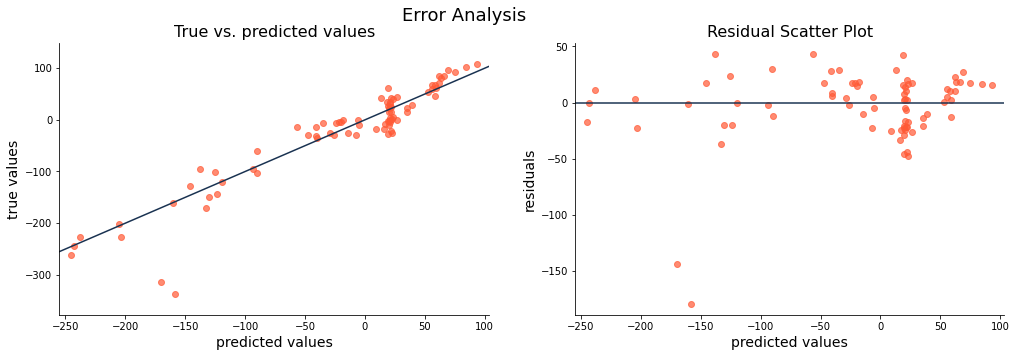

In [32]:
error_analysis(y_test, y_pred_test)

The residual plot for this model looks not totally bad for most parts. But there were two instances where our model predicted extremely bad. 



## "High variance" model



Ok... let's have one more look at what "high-variance" models mean.

Variance is the amount that the estimate of the target will change if different training data was used. How sensitive is the algorithm to the specific training data used.

To check what this exactly means in our case here, we will train now 3 nonflexible models (polynomials degree of 1) and 3 highly flexible models (polynomials degree of 8) on different training data!
And see how much those models vary from one another.

So first step is to create 2 other train test splits, to get 2 more training sets with which we can fit our models.

In [34]:
X_train_split2, X_test_split2, y_train_split2, y_test_split2 = train_test_split(x, y, test_size=0.8, random_state=91)
X_train_split3, X_test_split3, y_train_split3, y_test_split3 = train_test_split(x, y, test_size=0.8, random_state=222)

Now we will first use these new data to train 3 linear models:

In [35]:
# Model 1
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Model 2
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_train_split2, y_train_split2)

# Model 3
lin_reg_3 = LinearRegression()
lin_reg_3.fit(X_train_split3, y_train_split3)


LinearRegression()

Let's plot those three models to see how much they differ from one another!

In [36]:
y_plot_true = 10 * x_plot - 2 * (x_plot ** 2) + 0.5 * (x_plot ** 3)
line_lin_reg = lin_reg.intercept_ + lin_reg.coef_[0]*x_plot
line_lin_reg_2 = lin_reg_2.intercept_ + lin_reg_2.coef_[0]*x_plot
line_lin_reg_3 = lin_reg_3.intercept_ + lin_reg_3.coef_[0]*x_plot

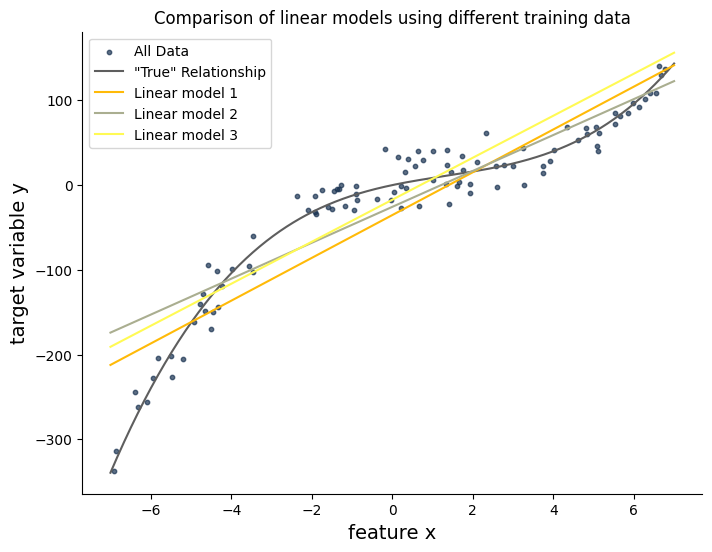

In [37]:
# Plotting 
plt.scatter(x, y, s=10,c="#193251",alpha=0.7, label="All Data")
#plt.scatter(X_test, y_test, s=10,c="#FF5A36",alpha=0.7, label="Test data")
plt.plot(x_plot,y_plot_true,c="#5E5E5E",label= '"True" Relationship')
plt.plot(x_plot,line_lin_reg,c="#FFBA08",label= 'Linear model 1')
plt.plot(x_plot,line_lin_reg_2,c="#AAAE90",label= 'Linear model 2')
plt.plot(x_plot,line_lin_reg_3,c="#FFFA54",label= 'Linear model 3')
plt.legend()
plt.xlabel("feature x")
plt.ylabel("target variable y")
plt.title("Comparison of linear models using different training data")
plt.show();

The three linear models aren't identical. But the intercepts and the scopes are pretty similar. 

These models aren't very sensitive to changes in training data.

Let's see how the more flexible models perform.

In [38]:
polynomial_features = PolynomialFeatures(degree=8, include_bias=False)
x_poly_train = polynomial_features.fit_transform(X_train)
x_poly_test = polynomial_features.transform(X_test)

polynomial_features = PolynomialFeatures(degree=8, include_bias=False)
x_poly_train_2 = polynomial_features.fit_transform(X_train_split2)
x_poly_test_2 = polynomial_features.transform(X_test_split2)

polynomial_features = PolynomialFeatures(degree=8, include_bias=False)
x_poly_train_3 = polynomial_features.fit_transform(X_train_split3)
x_poly_test_3 = polynomial_features.transform(X_test_split3)


# Flexible model 1
poly_reg = LinearRegression()
poly_reg.fit(x_poly_train, y_train)

# Flexible model 2
poly_reg_2 = LinearRegression()
poly_reg_2.fit(x_poly_train_2, y_train_split2)

# Flexible model 3
poly_reg_3 = LinearRegression()
poly_reg_3.fit(x_poly_train_3, y_train_split3)

LinearRegression()

In [39]:
y_plot_true = 10 * x_plot - 2 * (x_plot ** 2) + 0.5 * (x_plot ** 3)
line_poly_1 = poly_reg.intercept_ + poly_reg.coef_[0][0] * x_plot + poly_reg.coef_[0][1] * x_plot**2 + poly_reg.coef_[0][2] * x_plot**3 + poly_reg.coef_[0][3] * x_plot**4 + poly_reg.coef_[0][4] * x_plot**5 + poly_reg.coef_[0][5] * x_plot**6 + poly_reg.coef_[0][6] * x_plot**7 + poly_reg.coef_[0][7] * x_plot**8
line_poly_2 = poly_reg_2.intercept_ + poly_reg_2.coef_[0][0] * x_plot + poly_reg_2.coef_[0][1] * x_plot**2 + poly_reg_2.coef_[0][2] * x_plot**3 + poly_reg_2.coef_[0][3] * x_plot**4 + poly_reg_2.coef_[0][4] * x_plot**5 + poly_reg_2.coef_[0][5] * x_plot**6 + poly_reg_2.coef_[0][6] * x_plot**7 + poly_reg_2.coef_[0][7] * x_plot**8
line_poly_3 = poly_reg_3.intercept_ + poly_reg_3.coef_[0][0] * x_plot + poly_reg_3.coef_[0][1] * x_plot**2 + poly_reg_3.coef_[0][2] * x_plot**3 + poly_reg_3.coef_[0][3] * x_plot**4 + poly_reg_3.coef_[0][4] * x_plot**5 + poly_reg_3.coef_[0][5] * x_plot**6 + poly_reg_3.coef_[0][6] * x_plot**7 + poly_reg_3.coef_[0][7] * x_plot**8

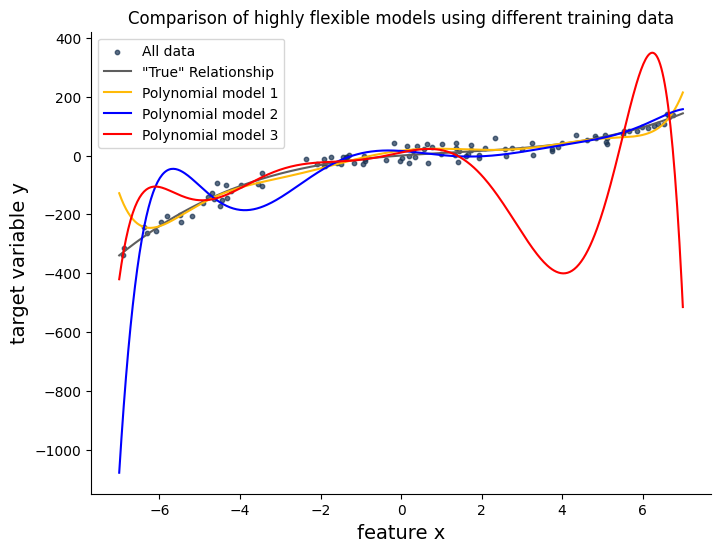

In [40]:
# Plotting 
plt.scatter(x, y, s=10,c="#193251",alpha=0.7, label="All data")
#plt.scatter(X_test, y_test, s=10,c="#FF5A36",alpha=0.7, label="Test data")
plt.plot(x_plot,y_plot_true,c="#5E5E5E",label= '"True" Relationship')
plt.plot(x_plot,line_poly_1,c="#FFBA08",label= 'Polynomial model 1')
plt.plot(x_plot,line_poly_2,c="b",label= 'Polynomial model 2')
plt.plot(x_plot,line_poly_3,c= "r",label= 'Polynomial model 3')
plt.legend()
plt.xlabel("feature x")
plt.ylabel("target variable y")
plt.title("Comparison of highly flexible models using different training data")
plt.show();

Again, we can see, that even though these flexible models fit the training data very well, they don't generalize well; they won't be able to predict well on unseen data. 
These flexible models change a lot depending on different training data: they are high-variance models! 

In order to understand how these curves came about, you can plot the training data for the individual curves separately from the test data!



## Summary



- In this notebook you have seen the typical data science workflow, starting with splitting the data into train and test set, trying out different models and evaluate their performance according to a specified metric and an error analysis.


- You learnt to create more flexible linear models by using polynomial features.


- You know that the bias-variance tradeoff is a basic concept in machine learning which will play a major role when applying any machine learning algorithm. 


- You know that Bias is the simplifying assumptions made by the model to make the target function easier to approximate.


- Variance is the amount that the estimate of the target function will change given different training data.


- The bias-variance Trade-off describes the fact, that it might be wise to use a biased estimator, so long as it reduces the variance, assuming our goal is to minimize the error function.




## Check your understanding



1. Calculate the RMSE (for train and test data) of the last 6 models (3 linear regression and 3 polynomial regression (order 8)). What do you expect?

2. Train (8) polynomial models with different degrees (from 1-8 polynomial degree) of features. Plot the train RMSE and test RMSE of the models over the model flexibilities (polynomial degree 1-8) according to the very first plot (from wikipedia) in this notebook. What trend do you see in the train RMSE and test RMSE and what explains these trends?

3. After trying out these different models, which model would you choose and why? 

4. What can you do to prevent overfitting?